Install and Imports Libraries

In [1]:
!pip install -q transformers accelerate datasets ftfy safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00


In [2]:
import os, random, time
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path

from transformers import AutoProcessor, AutoModel

Mount Drive and set Paths

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_DIR = "/content/drive/MyDrive/499A Datasets"
META_PATH  = os.path.join(BASE_DIR, "Dermnet", "Preprocessed", "metadata_augmented.csv")
HERB_PATH  = os.path.join(BASE_DIR, "Preprocessed", "herb2_final_clean.csv")

SAVE_DIR  = os.path.join(BASE_DIR, "Dermnet", "Pretrained_SigLIP")
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

print("Metadata:", META_PATH)
print("Herb text:", HERB_PATH)
print("Save directory:", SAVE_DIR)

Mounted at /content/drive
Metadata: /content/drive/MyDrive/499A Datasets/Dermnet/Preprocessed/metadata_augmented.csv
Herb text: /content/drive/MyDrive/499A Datasets/Preprocessed/herb2_final_clean.csv
Save directory: /content/drive/MyDrive/499A Datasets/Dermnet/Pretrained_SigLIP


Load metadata and herb2.0 text

In [4]:
meta = pd.read_csv(META_PATH)
herb = pd.read_csv(HERB_PATH, low_memory=False)
meta.columns = [c.strip() for c in meta.columns]
herb.columns = [c.strip() for c in herb.columns]

# Only keep train subset
train_meta = meta[meta['subset'].str.lower()=='train'].reset_index(drop=True)
test_meta  = meta[meta['subset'].str.lower()=='test'].reset_index(drop=True)

print("Train images:", len(train_meta))
print("Test images: ", len(test_meta))
print("Herb entries:", len(herb))

Train images: 38945
Test images:  10011
Herb entries: 44595


Load processor and setup device

In [5]:
# Auto-detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load processor for SigLIP
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Define Dataset Class

In [6]:
class SkinHerbDataset(Dataset):
    def __init__(self, image_meta, herb_texts, transform=None):
        self.image_meta = image_meta
        self.herb_texts = herb_texts
        self.transform = transform

    def __len__(self):
        return len(self.image_meta)

    def __getitem__(self, idx):
        row = self.image_meta.iloc[idx]
        img_path = row['image_path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        text = random.choice(self.herb_texts)  # random herb text
        return image, text

Load SigLIP model

In [7]:
# Load SigLIP safely for CPU or GPU
MODEL_NAME = "google/siglip-base-patch16-224"
model = AutoModel.from_pretrained(MODEL_NAME).to(device)

print("Loaded SigLIP model successfully on:", device)

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Loaded SigLIP model successfully on: cuda


Optimizer,Loss and Dataloader

In [8]:
# Optimizer and loss
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CosineEmbeddingLoss(margin=0.2)

# DataLoader
herb_texts = herb['text_for_vlm'].fillna('').astype(str).tolist()
train_ds = SkinHerbDataset(train_meta, herb_texts, transform=None)
train_dl = DataLoader(
    train_ds,
    batch_size=4 if device.type == 'cpu' else 32,   # smaller batch for CPU
    shuffle=True,
    num_workers=0 if device.type == 'cpu' else 2
)

print(f"Dataloader ready. Batch size = {train_dl.batch_size}")

Dataloader ready. Batch size = 32


Training Loop

In [9]:
# Custom collate function that uses the SigLIP processor to batch images & texts
def collate_fn(batch):
    images, texts = zip(*batch)
    inputs = processor(
        images=list(images),
        text=list(texts),
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    return inputs

# Rebuild DataLoader with the collate_fn
train_dl = DataLoader(
    train_ds,
    batch_size=4 if device.type == 'cpu' else 32,
    shuffle=True,
    num_workers=0 if device.type == 'cpu' else 2,
    collate_fn=collate_fn
)

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move inputs to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        img_emb = outputs.image_embeds
        txt_emb = outputs.text_embeds

        # Normalize embeddings
        img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
        txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)

        # Cosine embedding target (+1)
        target = torch.ones(img_emb.size(0)).to(device)
        loss = criterion(img_emb, txt_emb, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    print(f"Epoch {epoch+1}/{num_epochs} completed. Avg Loss: {avg_loss:.4f}")

    # Save model after each epoch
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"siglip_epoch{epoch+1}.pth"))

print("Training complete!")

Epoch 1/3:   0%|          | 0/1218 [00:00<?, ?it/s]

Epoch 1/3 completed. Avg Loss: 0.0104


Epoch 2/3:   0%|          | 0/1218 [00:00<?, ?it/s]

Epoch 2/3 completed. Avg Loss: 0.0002


Epoch 3/3:   0%|          | 0/1218 [00:00<?, ?it/s]

Epoch 3/3 completed. Avg Loss: 0.0003
Training complete!


Save porcessor

In [10]:
processor.save_pretrained(SAVE_DIR)
print("Processor saved successfully.")

Processor saved successfully.


Inference on Test set

In [31]:
import os
import pandas as pd
from PIL import Image
import torch
from tqdm.auto import tqdm
from transformers import AutoProcessor, AutoModel

# Paths and parameters
BASE_DIR = "/content/drive/MyDrive/499A Datasets"
META_PATH  = os.path.join(BASE_DIR, "Dermnet", "Preprocessed", "metadata_augmented.csv")
HERB_PATH  = os.path.join(BASE_DIR, "Preprocessed", "herb2_final_clean.csv")
SAVE_DIR  = os.path.join(BASE_DIR, "Dermnet/Pretrained_SigLIP")
MODEL_NAME = "google/siglip-base-patch16-224"
MODEL_CHECKPOINT = os.path.join(SAVE_DIR, "siglip_epoch3.pth")  # change if needed
TOP_N = 5
BATCH_SIZE = 64

os.makedirs(SAVE_DIR, exist_ok=True)

# Load metadata and herb text
meta = pd.read_csv(META_PATH)
herb = pd.read_csv(HERB_PATH, low_memory=False)

# Only test images
test_meta = meta[meta['subset'].str.lower() == 'test'].reset_index(drop=True)
herb_texts = herb['text_for_vlm'].fillna('').astype(str).tolist()

print("Number of test images:", len(test_meta))
print("Number of herb texts:", len(herb_texts))

# Device and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

processor = AutoProcessor.from_pretrained(MODEL_NAME)

# Load model
model = AutoModel.from_pretrained(MODEL_NAME)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location=device))
model.to(device)
model.eval()
print("Model loaded.")

# Encode all herb texts
all_herb_embs = []

with torch.no_grad():
    for i in tqdm(range(0, len(herb_texts), BATCH_SIZE), desc="Encoding Herbs"):
        batch_texts = herb_texts[i:i+BATCH_SIZE]
        inputs = processor(text=batch_texts, padding=True, truncation=True, return_tensors="pt").to(device)
        text_emb = model.get_text_features(**inputs)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        all_herb_embs.append(text_emb)

all_herb_embs = torch.cat(all_herb_embs, dim=0)
all_herb_embs = all_herb_embs.to(device)  # ensure same device
print("Herb embeddings shape:", all_herb_embs.shape)

# Inference on test images
test_results = []

with torch.no_grad():
    for idx, row in tqdm(test_meta.iterrows(), total=len(test_meta), desc="Inference"):
        img_path = row['image_path']
        try:
            img = Image.open(img_path).convert('RGB')
            img_inputs = processor(images=img, return_tensors="pt").to(device)
            img_emb = model.get_image_features(**img_inputs)
            img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)

            sims = (img_emb @ all_herb_embs.T).cpu().numpy().flatten()
            top_idxs = sims.argsort()[-TOP_N:][::-1]
            top_items = [(herb_texts[i], float(sims[i])) for i in top_idxs]

            test_results.append({
                "image_path": img_path,
                f"predicted_top{TOP_N}_herbs": top_items
            })

        except Exception as e:
            print("Error processing", img_path, e)
            continue

# Save predictions
out_path = os.path.join(SAVE_DIR, "test_predictions.csv")
pd.DataFrame(test_results).to_csv(out_path, index=False)
print("Predictions saved to:", out_path)

Number of test images: 10011
Number of herb texts: 44595
Using device: cuda
Model loaded.


Encoding Herbs:   0%|          | 0/697 [00:00<?, ?it/s]

Herb embeddings shape: torch.Size([44595, 768])


Inference:   0%|          | 0/10011 [00:00<?, ?it/s]

Predictions saved to: /content/drive/MyDrive/499A Datasets/Dermnet/Pretrained_SigLIP/test_predictions.csv


SigLIP prediction function

In [32]:
def predict_image_siglip(img_path, topk_herb=5):
    img = Image.open(img_path).convert("RGB")

    with torch.no_grad():
        # Encode Image
        img_inputs = processor(images=img, return_tensors="pt").to(device)
        img_emb = model.get_image_features(**img_inputs)
        img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)

        # Compute similarity with ALL herb text embeddings
        sims = (img_emb @ all_herb_embs.T).cpu().numpy().flatten()
        idxs = sims.argsort()[-topk_herb:][::-1]

        top_texts = [herb_texts[i] for i in idxs]
        top_scores = [float(sims[i]) for i in idxs]

    return {
        "image_path": img_path,
        "top_herb_texts": top_texts,
        "top_herb_scores": top_scores
    }

Prediction for a particular test image

Loaded 10011 predictions from: /content/drive/MyDrive/499A Datasets/Dermnet/Pretrained_SigLIP/test_predictions.csv

Displaying test image #100: /content/drive/MyDrive/499A Datasets/Dermnet/preprocessed/test/Acne and Rosacea Photos/acne-cystic-126.jpg


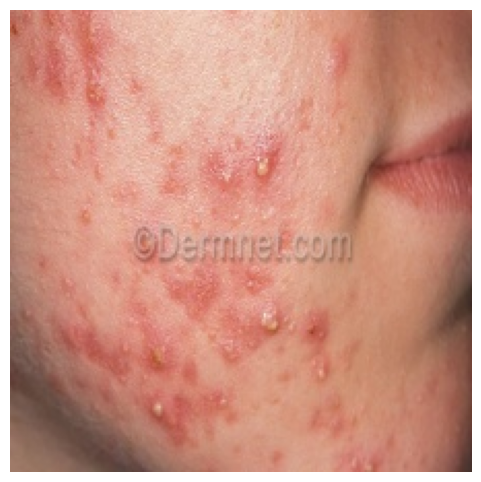


Top-5 Predicted Herbs for this image:

Rank 1 | Similarity: 0.9953
Upland Cress | Barbarea Vulgaris | 2',5,5',7-tetrahydroxyflavanone; (s)-form | C15H12O6 | Congenital Anomaly of Cerebrovascular System | Congenital Abnormality | Cardiovascular Diseases; Congenital, Hereditary, and Neonatal Diseases and Abnormalities; Nervous System Diseases

Rank 2 | Similarity: 0.9953
Chinese Iris Equivalent Plant: Iris Halophila | Semen Iridis | To clear heat and dispel damp, resolve toxin and kill worms, stanch bleeding and settle pain. | Jaundice, strangury-turbidity, inhibited urination [=dysuria], intestinal welling abscess, worm accumulation, malaria, wind-damp pain, [...]

Rank 3 | Similarity: 0.9953
Straw Mushroom | Fructificatio Volvarellae Volaceae | To clear heat and resolve summerheat, supplement qi and blood, lower blood pressure. | Summerheat-heat vexation and thirst, vacuity and hypodynamia, hypertension. | Sweet; Cold | 1-(2,4,5-trimethoxyphenyl)-1-methoxypropan-2-ol | C13H20O5 | [...

In [44]:
import matplotlib.pyplot as plt
import ast
from PIL import Image
import textwrap

# Path to saved predictions
RETRIEVAL_CSV = os.path.join(SAVE_DIR, "test_predictions.csv")

# Check if file exists and is not empty
if not os.path.exists(RETRIEVAL_CSV) or os.path.getsize(RETRIEVAL_CSV) == 0:
    print("No predictions file found or it's empty. Please rerun the inference section.")
else:
    # Load saved predictions
    df_out = pd.read_csv(RETRIEVAL_CSV)

    print(f"Loaded {len(df_out)} predictions from: {RETRIEVAL_CSV}")

    # Choose a test index to visualize
    idx = 100
    test_row = test_meta.iloc[idx]
    img_path = test_row["image_path"]

    print(f"\nDisplaying test image #{idx}: {img_path}")

    # Show the image
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Retrieve top herb predictions for this image
    preds_str = df_out.iloc[idx][f"predicted_top{TOP_N}_herbs"]

    try:
        preds = ast.literal_eval(preds_str)  # Convert string to list of tuples
        print(f"\nTop-{TOP_N} Predicted Herbs for this image:\n")
        for rank, (txt, score) in enumerate(preds, start=1):
            print(f"Rank {rank} | Similarity: {score:.4f}\n{textwrap.shorten(txt, width=300)}\n")
    except Exception as e:
        print("Error parsing predictions:", e)
        print(preds_str)